In [47]:
%load_ext autoreload
%autoreload 2

from run_models import load_model
from plot_utils import *
from DisruptionPredictors import DisruptionPredictorSM, DisruptionPredictorRF, DisruptionPredictorTinguely
from preprocess_datasets import ALL_FEATURES, DEFAULT_FEATURES
from Experiments import Experiment
from plot_experiments import *

horizons = np.linspace(0.001, 0.3, 11)

device = 'cmod'
#dataset = 'random100'
dataset = 'random_256_shots_60%_flattop'
test_dataset = dataset+'_test'
numeric_feats = ALL_FEATURES

# Load models and create disruption predictors

cph_model, cph_transformer = load_model('cph', device, dataset)
cph_predictor = DisruptionPredictorSM("Cox Proportional Hazards", cph_model, numeric_feats, cph_transformer)

dcph_model, dcph_transformer = load_model('dcph', device, dataset)
dcph_predictor = DisruptionPredictorSM("Deep Cox Proportional Hazards", dcph_model, numeric_feats, dcph_transformer)

dcm_model, dcm_transformer = load_model('dcm', device, dataset)
dcm_predictor = DisruptionPredictorSM("Deep Cox Mixture", dcm_model, numeric_feats, dcm_transformer)

dsm_model, dsm_transformer = load_model('dsm', device, dataset)
dsm_predictor = DisruptionPredictorSM("Deep Survival Machines", dsm_model, numeric_feats, dsm_transformer)

rsf_model, rsf_transformer = load_model('rsf', device, dataset)
rsf_predictor = DisruptionPredictorSM("Random Survival Forest", rsf_model, numeric_feats, rsf_transformer)

rf_model, rf_transformer = load_model('rf', device, dataset)
rf_predictor = DisruptionPredictorRF("Random Forest", rf_model, numeric_feats, rf_transformer)

ting_model, ting_transformer = load_model('rf', device, dataset)
ting_predictor = DisruptionPredictorTinguely("Tinguely et al. 2019", ting_model, numeric_feats, ting_transformer)

# Create experiments for each predictor
cph_experiment = Experiment(device, test_dataset, cph_predictor, 'CPH')
dcph_experiment = Experiment(device, test_dataset, dcph_predictor, 'DCPH')
dcm_experiment = Experiment(device, test_dataset, dcm_predictor, 'DCM')
dsm_experiment = Experiment(device, test_dataset, dsm_predictor, 'DSM')
rsf_experiment = Experiment(device, test_dataset, rsf_predictor, 'RSF')
rf_experiment = Experiment(device, test_dataset, rf_predictor, 'RF')
ting_experiment = Experiment(device, test_dataset, ting_predictor, 'Tinguely')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded model from models/cph_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/dcph_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/dcm_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/dsm_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/rsf_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/rf_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/rf_cmod_random_256_shots_60%_flattop.pkl


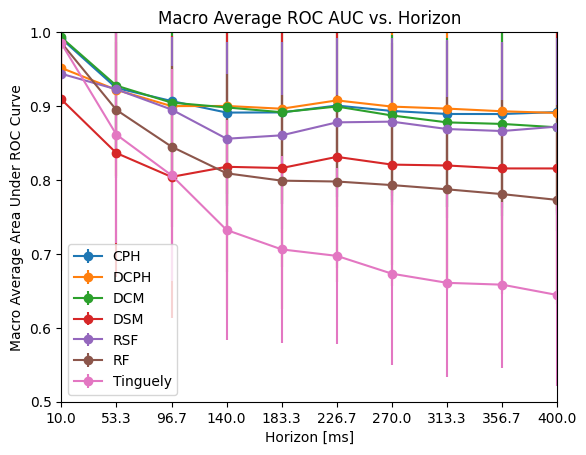

In [56]:
# Run the experiments
experiment_list = [cph_experiment, dcph_experiment, dcm_experiment, dsm_experiment, rsf_experiment, rf_experiment, ting_experiment]
#experiment_list = [ting_experiment]
plot_roc_auc_vs_horizon_macro(experiment_list)



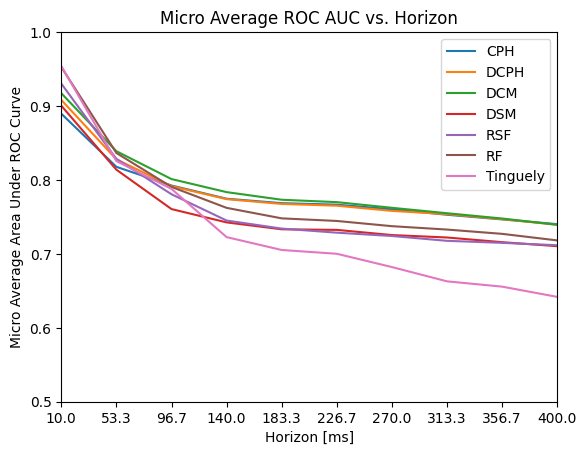

In [57]:
plot_roc_auc_vs_horizon_micro(experiment_list)

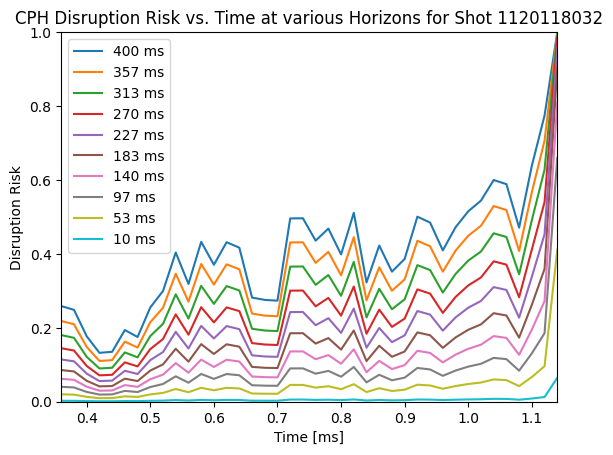

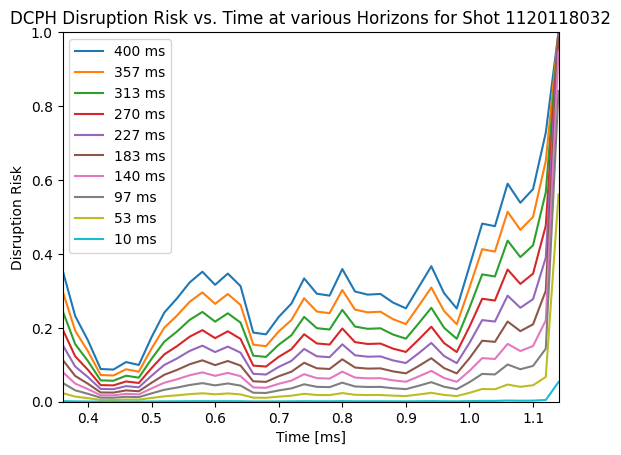

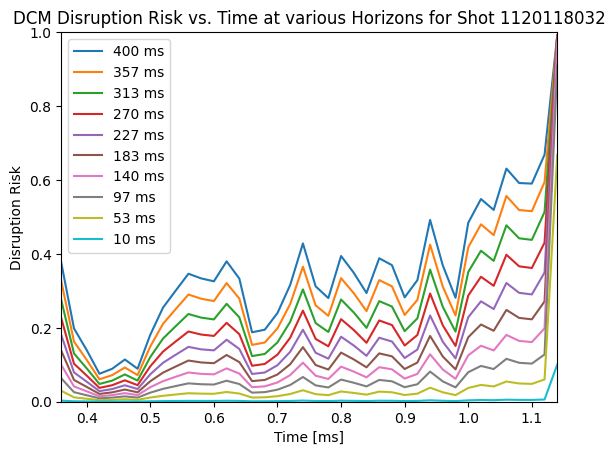

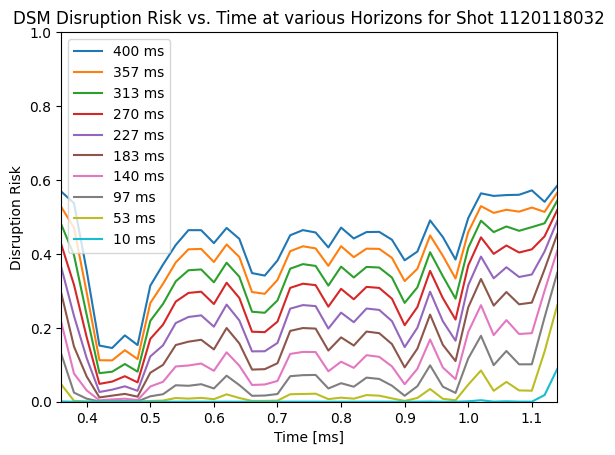

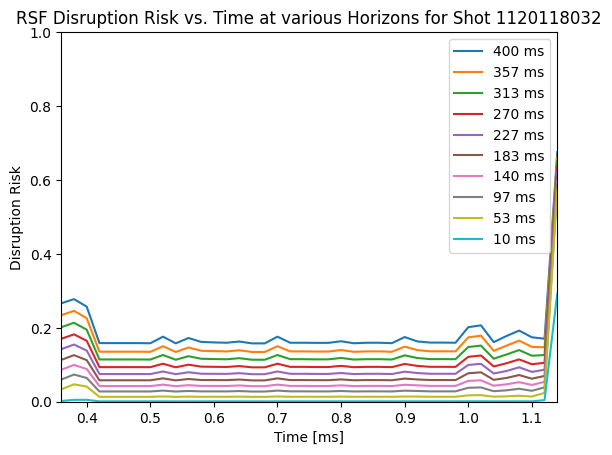

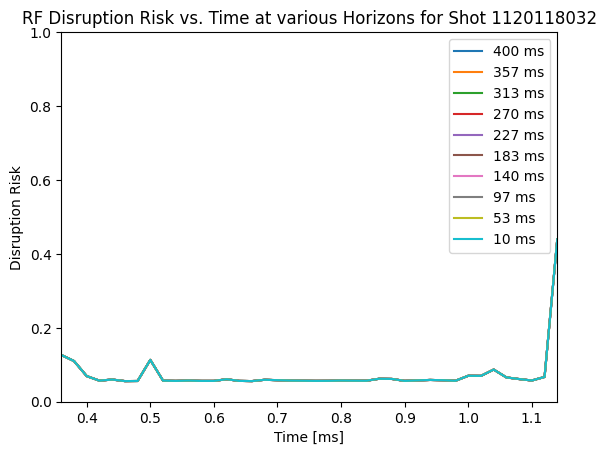

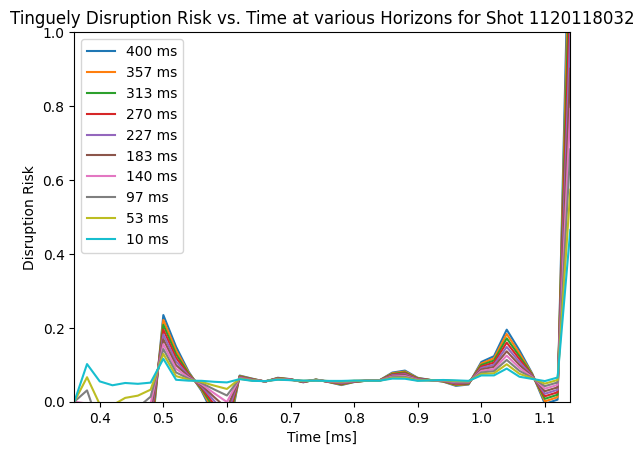

In [60]:
for experiment in experiment_list:
    plot_risk_compare_horizons(experiment, experiment.get_disruptive_shot_list()[1])